In [46]:
import zipfile as ZipFile
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from PIL import Image

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
train_image = "/content/drive/MyDrive/Tamil Dataset/Tamil Uriye Eluthukal/train-image-1591211703.9039922.npy"
train_label = "/content/drive/MyDrive/Tamil Dataset/Tamil Uriye Eluthukal/train-label-1591211706.368335-onehot.npy"

In [31]:
train_X = np.load(train_image)
train_y = np.load(train_label)

In [88]:
train_X.shape

(60000, 784)

[0 0 0 0 0 0 0 0 0 0 0 0 1]
12


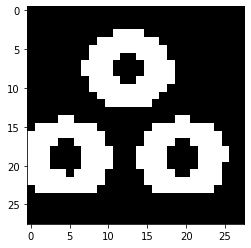

In [257]:
index = 90
plt.imshow(train_X[index].reshape(28,28),cmap="gray")
print(train_y[index])
print(train_y[index].argmax())

In [258]:
class TamilLang(Dataset):

  def __init__(self,X,y,transform=None):
    self.X = X
    self.y = y
    self.transform = transform

  def __len__(self):
    return len(self.X)

  def __getitem__(self,index):
    x = Image.fromarray(self.X[index].reshape(28,28))
    y = self.y[index].argmax()

    if self.transform != None:
      x = self.transform(x)
    
    return x,y


In [259]:
train_transforms =  transforms.Compose([
        # transforms.Resize((28, 28)),
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
])

In [260]:
train_dataset =  TamilLang(train_X,train_y,train_transforms)

In [261]:
train_dataset.transform

Compose(
    ToTensor()
)

In [262]:
train_datasetLoader = DataLoader(train_dataset,batch_size=100,shuffle=True)

torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([1, 28, 28])
torch.Size([])
tensor(9)


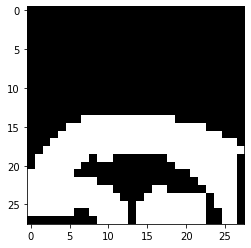

In [263]:
tdl = iter(train_datasetLoader)
tdl = next(tdl)
print(tdl[0].shape) # this is the shape of images along with the batch size (100,1,28,28)
print(tdl[1].shape) # this is the shape of labels along with the batch size (100,13)
print(tdl[0][0].shape) # this is the shape of images alone (1,28,28)
print(tdl[1][0].shape) # this is the shape of label alone
plt.imshow(tdl[0][9].reshape(28,28),cmap="gray") # this is a image
print(tdl[1][9]) # this is the corresponding label

In [264]:
config = [
     # input_channels:int,no.of filters:int,filter_size:int,stride:int,padding:int
     (1,16,3,2,0),
     # MP - max pooling:string,filter_size:int,stride:int,padding:int
     ("MP",2,2,0),
     (16,32,3,2,0),
     ("MP",2,2,0),
]

In [265]:
def conv_output_size(img_size,padding,filter_size,stride,n_filters):
   size_ = (int((img_size + (2 * padding) - filter_size) / stride)) + 1
   return size_,size_,n_filters

In [266]:
def dense_layer_size(configuration,img_size):

  _,output_channels = 0,0
  layer_count = 0

  for config in configuration:
    
    layer_count += 1

    if config[0] == "MP":
      img_size,_,output_channels = conv_output_size(img_size,config[3],config[1],config[2],output_channels)
      print("Max Pooling Layer {} output dims :: ".format(layer_count),img_size,_,output_channels)

    else: 
      img_size,_,output_channels = conv_output_size(img_size,config[4],config[2],config[3],config[1])
      print("Conv Layer {} output dims :: ".format(layer_count),img_size,_,output_channels)
  
  return img_size,_,output_channels

In [267]:
width,heigth,channels = dense_layer_size(config,28)

Conv Layer 1 output dims ::  13 13 16
Max Pooling Layer 2 output dims ::  6 6 16
Conv Layer 3 output dims ::  2 2 32
Max Pooling Layer 4 output dims ::  1 1 32


In [268]:
width * heigth * channels

32

In [284]:
class NeuralNet(nn.Module):

  def __init__(self):
    super(NeuralNet,self).__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(1,16,3,2),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(16,32,3,2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )

    self.FC = nn.Sequential(
        nn.Linear(32,13),
        # nn.Softmax(dim=1)
    )

  def forward(self,x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = torch.flatten(x, 1)
    x = self.FC(x)
    return x


In [285]:
model = NeuralNet()

In [286]:
model.train()
print(model)

NeuralNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (FC): Sequential(
    (0): Linear(in_features=32, out_features=13, bias=True)
  )
)


In [287]:
lr = 0.01
loss_fn = nn.CrossEntropyLoss() # reffer this blog https://neptune.ai/blog/pytorch-loss-functions
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

In [288]:
epochs = 30

all_epochs_loss = []
all_epochs_acc = []

for epoch in range(epochs):

  epoch_loss = 0
  epoch_accuracy = 0

  for batch_id,(image,label) in enumerate(train_datasetLoader):
  
    prediction = model(image)
    loss = loss_fn(prediction,label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    acc = (prediction.argmax(dim=1) == label).float().mean()
    epoch_loss += (loss.item() / len(train_datasetLoader)) * 100
    epoch_accuracy += (acc.item() / len(train_datasetLoader)) * 100
   
    all_epochs_loss.append(epoch_loss)  
    all_epochs_acc.append(epoch_accuracy) 
    

  print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))


Epoch : 1, train accuracy : 64.77500009723023, train loss : 96.00643054644259
Epoch : 2, train accuracy : 73.28000005086271, train loss : 67.87131581207116
Epoch : 3, train accuracy : 74.94833322366078, train loss : 62.85683769484361
Epoch : 4, train accuracy : 76.08833322922388, train loss : 59.54985821743807
Epoch : 5, train accuracy : 76.73833321531616, train loss : 57.753626435995116
Epoch : 6, train accuracy : 77.12999980648357, train loss : 56.13839901487038
Epoch : 7, train accuracy : 77.41333320736885, train loss : 55.155193656683
Epoch : 8, train accuracy : 77.91833308339112, train loss : 54.170921549201076
Epoch : 9, train accuracy : 77.88833336035414, train loss : 53.52834207316249
Epoch : 10, train accuracy : 78.14166643222171, train loss : 52.77176231145856
Epoch : 11, train accuracy : 78.38333317637449, train loss : 52.029517595966716
Epoch : 12, train accuracy : 78.6049995720387, train loss : 51.5277935216824
Epoch : 13, train accuracy : 78.6216665407022, train loss : 51

In [289]:
torch.save(model.state_dict(), "TLModel30_1.pt")

In [290]:
model.load_state_dict(torch.load("/content/TLModel30_1.pt"))

<All keys matched successfully>

In [291]:
model.train()
print(model)

NeuralNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (FC): Sequential(
    (0): Linear(in_features=32, out_features=13, bias=True)
  )
)


In [292]:
epochs = 30

all_epochs_loss = []
all_epochs_acc = []

for epoch in range(epochs):

  epoch_loss = 0
  epoch_accuracy = 0

  for batch_id,(image,label) in enumerate(train_datasetLoader):
  
    prediction = model(image)
    loss = loss_fn(prediction,label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    acc = (prediction.argmax(dim=1) == label).float().mean()
    epoch_loss += (loss.item() / len(train_datasetLoader)) * 100
    epoch_accuracy += (acc.item() / len(train_datasetLoader)) * 100
   
    all_epochs_loss.append(epoch_loss)  
    all_epochs_acc.append(epoch_accuracy) 
    

  print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))


Epoch : 1, train accuracy : 79.71499995390575, train loss : 46.249087373415584
Epoch : 2, train accuracy : 80.0666663944722, train loss : 46.218966312706435
Epoch : 3, train accuracy : 80.2349999646346, train loss : 45.86922058463093
Epoch : 4, train accuracy : 79.95666653911287, train loss : 45.92576714853446
Epoch : 5, train accuracy : 80.23499981562303, train loss : 45.836245946586104
Epoch : 6, train accuracy : 80.53833324710541, train loss : 45.54290363689264
Epoch : 7, train accuracy : 80.25999984145174, train loss : 45.53082566708323
Epoch : 8, train accuracy : 80.23166647553452, train loss : 45.4509313702583
Epoch : 9, train accuracy : 80.34333320458737, train loss : 45.28869015971818
Epoch : 10, train accuracy : 80.4733330706756, train loss : 45.05598041911921
Epoch : 11, train accuracy : 80.37333315610894, train loss : 45.092332089940754
Epoch : 12, train accuracy : 80.48166645566627, train loss : 44.99023190140723
Epoch : 13, train accuracy : 80.39999967813506, train loss : 

In [293]:
torch.save(model.state_dict(), "TLModel30_2.pt")